# Global ECMWF Fire Forecasting - ERA5 based reanalysis of the Fire Weather Index

Import the necessary libraries and enable inline displaying of plots

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline

ModuleNotFoundError: No module named 'xarray'

### Get data

Explore the list of available fire danger indices on the Zenodo repository (wildfire community): https://zenodo.org/communities/wildfire. 

Go to FWI and download ‘fwi.nc’.

In [2]:
# Open fwi.nc as dataset
ds = xr.open_dataset("/scratch/rd/nen/perClaudia/era5/fwi.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 640, lon: 1280, time: 14245)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
  * lon      (lon) float32 -180.0 -179.71875 -179.4375 ... 179.4375 179.71875
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.6 (http://mpimet.mp...
    history:           Thu Jun 27 23:05:59 2019: cdo --silent cat /scratch/rd...
    Conventions:       CF-1.6
    Reference date:    19800101
    ECMWF fire model:  3.0
    Lincense:          Copernicus
    version:           3.0
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.6 (http://mpimet.mp...

In [3]:
# Convert ds to a dataarray extracting only the variable fwi
da = ds.fwi
da

<xarray.DataArray 'fwi' (time: 14245, lat: 640, lon: 1280)>
[11669504000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
  * lon      (lon) float32 -180.0 -179.71875 -179.4375 ... 179.4375 179.71875
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
Attributes:
    units:    -
    title:    Fire Weather Index

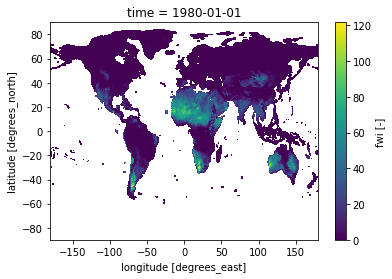

In [4]:
# Plot the first reanalysis layer (1980-01-01)
fwi = da[0]
fwi.plot();

### Extract a sub-cube by slicing over three dimensions

In [5]:
# Crop over are of interest, note lat = slice(top, bottom), lon = slice(left, right)!
# Use this service to get coordinates: https://boundingbox.klokantech.com/
# Scandinavia
fwi = da.loc[dict(time = slice('1980-01-01', '1983-01-01'), lat = slice(71.5, 54), lon = slice(4, 31.5))]
fwi

<xarray.DataArray 'fwi' (time: 1097, lat: 62, lon: 98)>
[6665372 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1983-01-01
  * lon      (lon) float32 4.21875 4.5 4.78125 5.0625 ... 30.9375 31.21875 31.5
  * lat      (lat) float32 71.241165 70.96014 70.67911 ... 54.379368 54.098335
Attributes:
    units:    -
    title:    Fire Weather Index

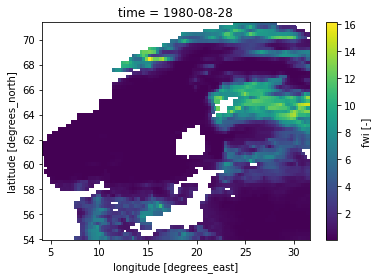

In [6]:
# Plot a layer in August (1980-08-28)
fwi[30*8,:,:].plot();

What is the mean value over the area for each day?

In [7]:
fwi_mean = fwi.mean(dim = ('lon', 'lat'))

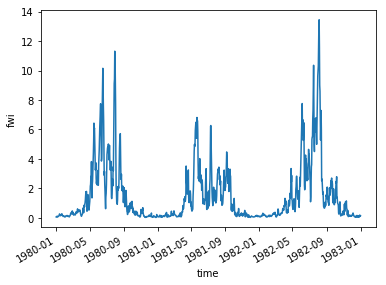

In [8]:
# Plot the mean value over the 3 year period
fwi_mean.plot();

### Fixed Danger Levels

Some examples of FWI thresholds currently in use:

* JRC (pan-European): 
  - Very Low = 0-5.2,
  - Low = 5.2-11.2,
  - Moderate = 11.2-21.3,
  - High = 21.3-38.0,
  - Very High = 38-50.0,
  - Extreme = >50
  
* CANADA:
  - Very Low = 0-1,
  - Low = 2-4,
  - Moderate = 5-8,
  - High = 9-16,
  - VeryHigh = 17-30,
  - Extreme => 30
  
* Portugal:
  - Reduced risk = 8.4,
  - Moderate risk = 17.2,
  - High risk = 24.6,
  - Maximum risk = 38.3
  
Thresholds are very different as they have been calibrated on specific areas (depending on local vegetation characteristics and fire regimes). This require local knowledge and/or experimentation.

A more data-driven way to derive danger thresholds consists of evaluating percentiles. For instance the set below usually corresponds to very low, low, moderate, high, very high and extreme danger: 

In [10]:
# Define percentiles of interest to generate danger threshold maps
fire_percentiles = [0.50, 0.75, 0.85, 0.90, 0.95, 0.98]

Below are two different approaches.

#### Regional Danger Levels

If the same thresholds have to be used throughtout the year and for large areas, the percentiles can be simply calculated over to the full time series record and then spatially averaged. In the example below, we apply the percentiles to a 3 year record to keep the processing time short. In real cases it is suggested to use a 30 year period.

In [11]:
# Calculate the maps of percentiles as threshold of danger
danger_threshold_maps = fwi.quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)
danger_threshold_maps

/usr/local/apps/python3/3.6.8-01/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


<xarray.DataArray 'fwi' (quantile: 6, lat: 62, lon: 98)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,  0.227328,  0.211729],
        [      nan,       nan, ...,  0.276445,  0.254512]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,  0.943854,  0.922242],
        [      nan,       nan, ...,  1.456013,  1.458166]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,  9.676562,  9.337367],
        [      nan,       nan, ..., 10.644199, 10.329878]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 15.595007,

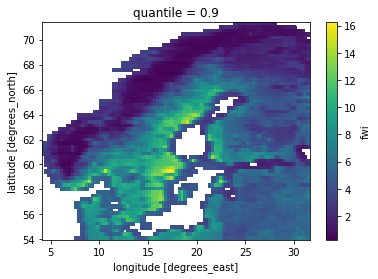

In [12]:
# Plot map of 90th percentile
danger_threshold_maps[3,:,:].plot();

In [13]:
# Obtain fixed set of thresholds as the median over the area for each time step (as integers)
# Very low = 0
# Low = 1
# Moderate = 3
# High = 5
# Very high = 8
# Extreme = 12
danger_threshold_maps.median(dim=('lon', 'lat')).round(0)

<xarray.DataArray 'fwi' (quantile: 6)>
array([ 0.,  1.,  3.,  5.,  8., 12.])
Coordinates:
  * quantile  (quantile) float64 0.5 0.75 0.85 0.9 0.95 0.98

This approach generally tends to underestimate danger levels because the sample contains many low values occurring during autumn and winter months. As an alternative, one could only consider records during the fire season (if known in advance). Let's assume the fire season in scandinavia goes from June to August (JJA):

In [36]:
# Find indices corresponding to JJA
idx = np.concatenate(np.where((fwi.time.dt.month >= 6)  & (fwi.time.dt.month <= 8)))

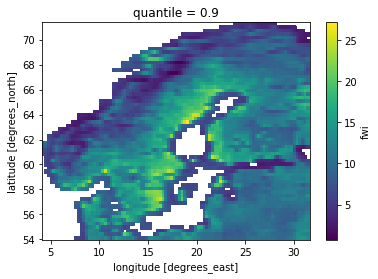

In [38]:
# Calculate quantiles only over JJA
danger_threshold_maps_JJA = fwi[idx,:,:].quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)
# Plot map of 90th percentile
danger_threshold_maps_JJA[3,:,:].plot();

In [39]:
# Obtain fixed set of thresholds as the median over the area for each time step
danger_threshold_maps_JJA.median(dim=('lon', 'lat')).round(0)

<xarray.DataArray 'fwi' (quantile: 6)>
array([ 1.,  5.,  8., 10., 13., 16.])
Coordinates:
  * quantile  (quantile) float64 0.5 0.75 0.85 0.9 0.95 0.98

This approach relies on the a-priori estimate of the length of the fire season, which is not always trivial. Also, spatial averaging over large regions should be avoided (if possible) to remove smoothing effects. In this case, for instance, south-east Scandinavia is climatologically very different from north-west Scandinavia. Summers are much warmer and therefore more prone to fires. 

#### Maps of danger levels based on the daily fire climatology

More often, local authorities estimate statistical thresholds based on the daily climatology on a cell-by-cell basis. The thresholds are delivered in the form of a map, which allows to avoid any smoothing effect due to spatial averaging. 
To understand how this works, let's assume we want to estimate danger level maps for 10th July.

In [19]:
# Find indices of dates corresponding to 10th July
idx = np.concatenate(np.where((fwi.time.dt.day == 10) & (fwi.time.dt.month == 7)))

array([191, 556, 921])

Let's expand this range of indices to include 4 days before and after each date

In [15]:
indices_list = []
for i in idx:
    indices_list.append(list(range(i - 4, i + 4 + 1)))

In [20]:
# Concatenate all the indices in a 1-dimensional array
indices = np.concatenate(indices_list)

array([187, 188, 189, 190, 191, 192, 193, 194, 195, 552, 553, 554, 555,
       556, 557, 558, 559, 560, 917, 918, 919, 920, 921, 922, 923, 924,
       925])

In [21]:
# Calculate the maps of percentiles as threshold of danger
fwi10July = fwi[indices,:,:]
daily_danger_threshold_maps = fwi10July.quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)

/usr/local/apps/python3/3.6.8-01/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


<xarray.DataArray 'fwi' (quantile: 6, lat: 62, lon: 98)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,  0.60321 ,  0.804392],
        [      nan,       nan, ...,  0.771188,  0.654114]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,  4.557807,  4.177574],
        [      nan,       nan, ...,  5.615366,  5.513969]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 13.542564, 13.599486],
        [      nan,       nan, ..., 15.296131, 14.648298]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 14.854416,

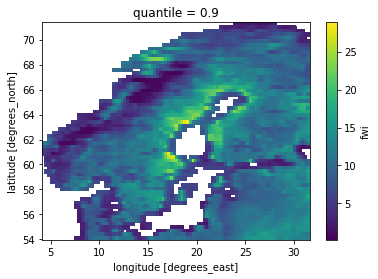

In [22]:
# Plot the map of daily climatological 90th percentile as threshold of high danger
daily_danger_threshold_maps[3].plot();

This map is very similar to the one calculated previously, which means that the fire weather in Scandinavia does not vary much over during the fire season.